## Step 1: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from lifelines import KaplanMeierFitter, CoxPHFitter 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
import warnings

## Step 2: Load and Explore the Dataset

In [4]:
data = pd.read_csv(r"C:\Users\AKHILK\Downloads\Breast Cancer METABRIC.csv")

In [37]:
# rounding age column
data["Age at Diagnosis"] = data["Age at Diagnosis"].astype(float).round()

In [6]:
# Filling missing values
for col in data.columns:
    if data[col].dtype == "object":
        data[col] = data[col].fillna(data[col].mode()[0])
    else:
        data[col] = data[col].fillna(data[col].median())

In [7]:
# Handling outliers
num_cols = data.select_dtypes(include=['number']).columns
for col in num_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = np.clip(data[col], lower_bound, upper_bound)

In [8]:
# Label encoding for categorical features
cat_cols = data.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in cat_cols:
    data[col] = label_encoder.fit_transform(data[col])


In [9]:
# Feature selection
selected_features = [
    "Age at Diagnosis", "Cancer_type_Detailed", "Cancer Type",
    "Type of Breast Surgery", "Cellularity", "Cohort",
    "Patient ID", "Chemotherapy"
]

In [10]:
X = data[selected_features]
y = data["Overall Survival Status"]

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [13]:
# Random Forest model with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}
rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [14]:
# Evaluation
print("--- Random Forest ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Save the model, scaler, and label encoder
joblib.dump(rf, r"C:\Users\AKHILK\BIA\Capstone\Random_Forest.joblib")
joblib.dump(scaler, r"C:\Users\AKHILK\BIA\Capstone\scaler.joblib")
joblib.dump(label_encoder, r"C:\Users\AKHILK\BIA\Capstone\label_encoders.joblib")


--- Random Forest ---
Accuracy: 0.7609561752988048
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       342
           1       0.65      0.54      0.59       160

    accuracy                           0.76       502
   macro avg       0.73      0.70      0.71       502
weighted avg       0.75      0.76      0.75       502



['C:\\Users\\AKHILK\\BIA\\Capstone\\label_encoders.joblib']

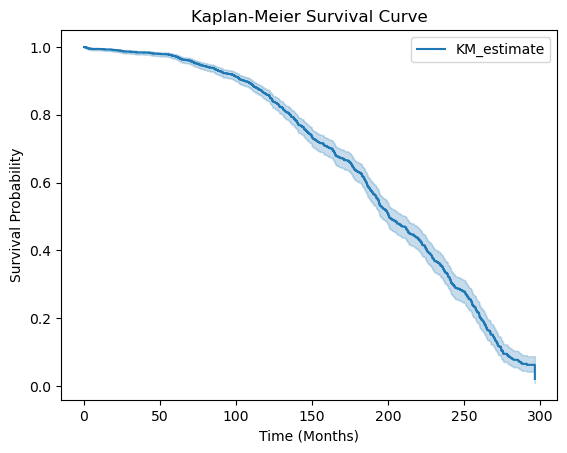

In [15]:
# Kaplan-Meier Survival Curve
kmf = KaplanMeierFitter()
kmf.fit(durations=data['Overall_Survival_Months'], event_observed=data['Overall Survival Status'])
kmf.plot()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.show()




<lifelines.CoxPHFitter: fitted with 2509 total observations, 1672 right-censored observations>
             duration col = 'Overall_Survival_Months'
                event col = 'Overall Survival Status'
      baseline estimation = breslow
   number of observations = 2509
number of events observed = 837
   partial log-likelihood = -5284.03
         time fit was run = 2025-04-14 17:57:36 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Age at Diagnosis -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00

                  cmp to     z      p  -log2(p)
covariate                                      
Age at Diagnosis    0.00 -3.14 <0.005      9.22
---
Concordance = 0.53
Partial AIC = 10570.06
log-likelihood ratio test = 9.83 on 1 df
-log2(p) of ll-ratio test = 9.19

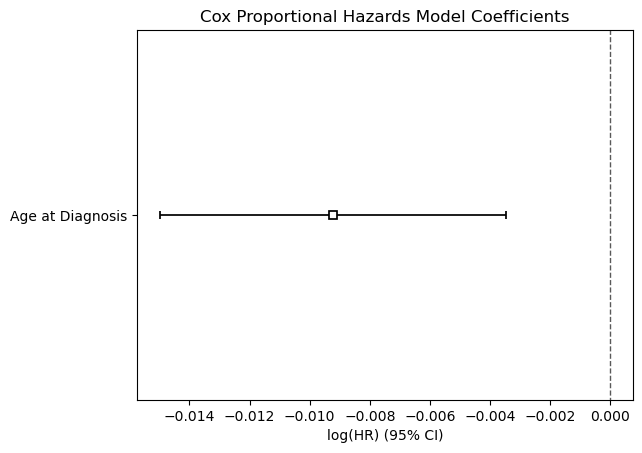

In [16]:
# Cox Proportional Hazards Model
cph = CoxPHFitter()
# Select relevant features for Cox model. 
cox_features = ['Age at Diagnosis', 'Overall_Survival_Months','Overall Survival Status'] # Add other features.
cph.fit(data[cox_features], duration_col='Overall_Survival_Months', event_col='Overall Survival Status')
cph.print_summary()

# Plot Cox model coefficients
cph.plot()
plt.title('Cox Proportional Hazards Model Coefficients')
plt.show()